<a href="https://colab.research.google.com/github/ayush-2405/Stock-Market-Prediction/blob/main/LSTM_Model_Stock_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

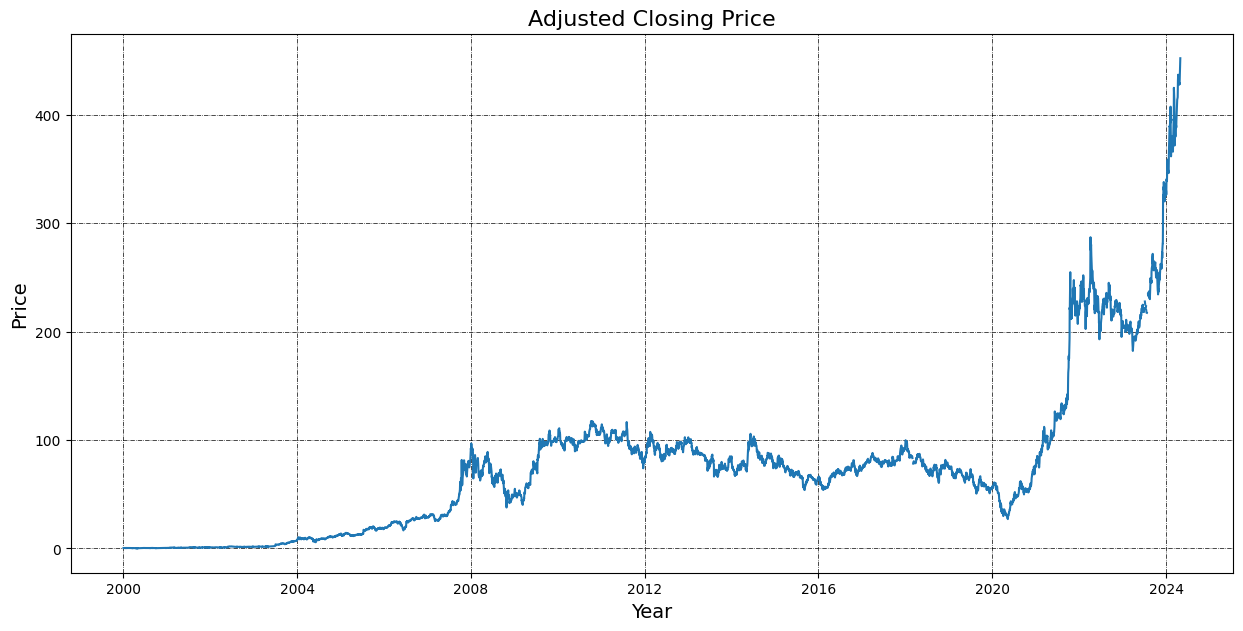

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from copy import deepcopy as dc
from sklearn.preprocessing import MinMaxScaler

ds=pd.read_csv('TATAPOWER.BO.csv')

ds=ds[['Date','Adj Close']]

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

ds['Date'] = pd.to_datetime(ds['Date'])

plt.figure(figsize=(15,7))
plt.plot(ds['Date'], ds['Adj Close'], )
plt.title("Adjusted Closing Price", fontsize=16)

plt.ylabel('Price', fontsize=14)
plt.xlabel('Year', fontsize=14)

plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
plt.show()



In [3]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    df.set_index('Date', inplace=True)

    for i in range(1, n_steps+1):
        df[f'Adj Close(t-{i})'] = df['Adj Close'].shift(i)

    df.dropna(inplace=True)

    return df


lookback = 7
shifted_ds = prepare_dataframe_for_lstm(ds, lookback)
shifted_ds

,Adj Close,Adj Close(t-1),Adj Close(t-2),Adj Close(t-3),Adj Close(t-4),Adj Close(t-5),Adj Close(t-6),Adj Close(t-7)
Date,,,,,,,,
2000-01-12,0.457903,0.443730,0.475347,0.440187,0.441549,0.430647,0.420562,0.421380
2000-01-13,0.441549,0.457903,0.443730,0.475347,0.440187,0.441549,0.430647,0.420562
2000-01-14,0.446456,0.441549,0.457903,0.443730,0.475347,0.440187,0.441549,0.430647
2000-01-17,0.445365,0.446456,0.441549,0.457903,0.443730,0.475347,0.440187,0.441549
2000-01-18,0.430647,0.445365,0.446456,0.441549,0.457903,0.443730,0.475347,0.440187
...,...,...,...,...,...,...,...,...
2024-04-24,428.350006,429.399994,427.899994,428.000000,429.899994,430.350006,431.500000,437.049988
2024-04-25,431.500000,428.350006,429.399994,427.899994,428.000000,429.899994,430.350006,431.500000
2024-04-26,436.750000,431.500000,428.350006,429.399994,427.899994,428.000000,429.899994,430.350006


In [5]:
shifted_ds_in_np = shifted_ds.to_numpy()

shifted_ds_in_np
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
shifted_ds_in_np = scaler.fit_transform(shifted_ds_in_np)

shifted_ds_in_np

X= shifted_ds_in_np[:,1:]
y=shifted_ds_in_np[:,0]

X.shape, Y.shape
import numpy as np
from copy import deepcopy as dc
X = dc(np.flip(X, axis=1))

split_index = int(len(X) * 0.90)

X_train = X[:split_index]
X_test = X[split_index:]

Y_train = y[:split_index]
Y_test = y[split_index:]

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((4958, 7), (551, 7), (4958,), (551,))

In [6]:
shifted_ds_in_np.shape

(5509, 8)

In [7]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = Y_train.reshape((-1, 1))
y_test = Y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4958, 7, 1), (551, 7, 1), (4958, 1), (551, 1))

In [8]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([4958, 7, 1]),
 torch.Size([551, 7, 1]),
 torch.Size([4958, 1]),
 torch.Size([551, 1]))

In [9]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [10]:
from torch.utils.data import DataLoader

batch_size = 512

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [11]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([512, 7, 1]) torch.Size([512, 1])


In [12]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 16, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 16, batch_first=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

In [13]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [14]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [15]:
learning_rate = 0.001
num_epochs = 256
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1

Val Loss: 0.563
***************************************************

Epoch: 2

Val Loss: 0.446
***************************************************

Epoch: 3

Val Loss: 0.348
***************************************************

Epoch: 4

Val Loss: 0.302
***************************************************

Epoch: 5

Val Loss: 0.312
***************************************************

Epoch: 6

Val Loss: 0.328
***************************************************

Epoch: 7

Val Loss: 0.323
***************************************************

Epoch: 8

Val Loss: 0.306
***************************************************

Epoch: 9

Val Loss: 0.291
***************************************************

Epoch: 10

Val Loss: 0.282
***************************************************

Epoch: 11

Val Loss: 0.272
***************************************************

Epoch: 12

Val Loss: 0.255
***************************************************

Epoch: 13

Val Loss: 0.239
**********************

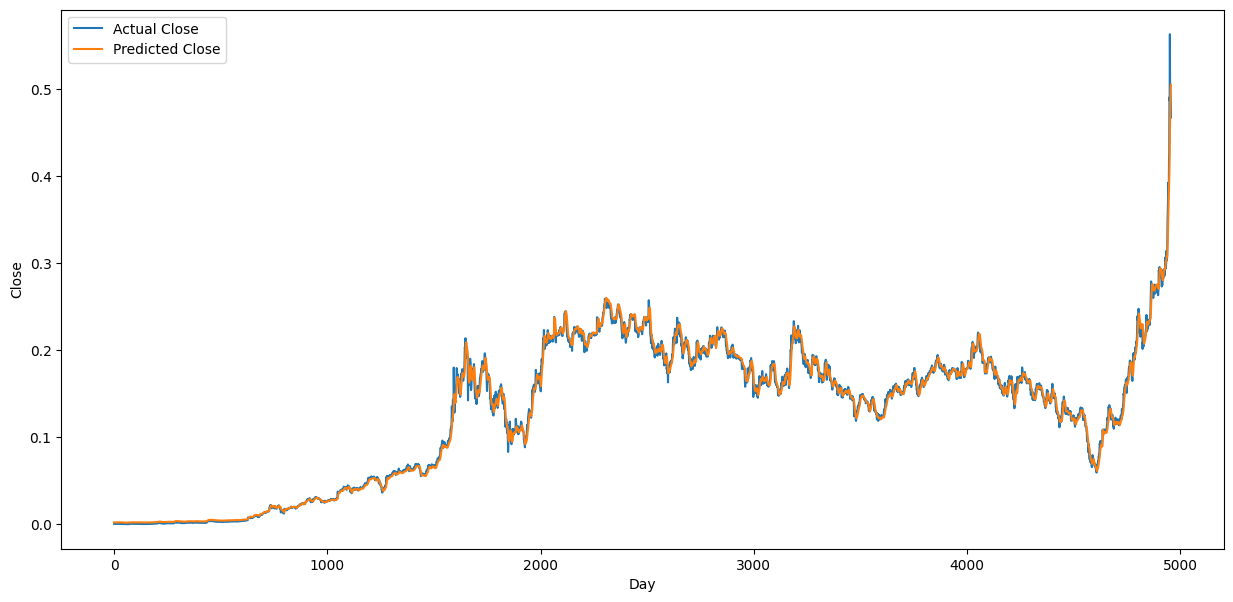

In [16]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.figure(figsize=(15,7))
plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [17]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([  1.22891594,   1.2335211 ,   1.23454148, ..., 224.48495621,
       227.31890575, 228.63522369])

In [18]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([  0.45790301,   0.44154901,   0.446456  , ..., 223.96369593,
       220.09968585, 211.62861687])

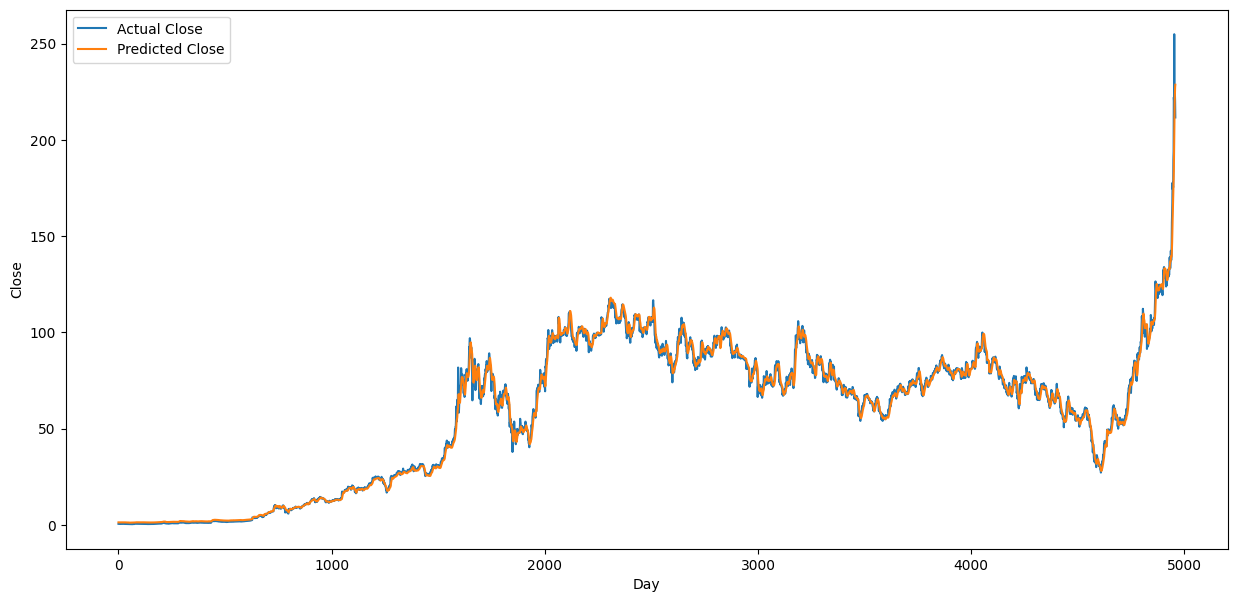

In [19]:

plt.figure(figsize=(15,7))
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [20]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([226.04347018, 226.01620629, 223.20538526, 221.5198194 ,
       219.34673636, 219.52298179, 221.0231963 , 222.93226141,
       224.23020586, 226.11418927, 229.66968902, 232.04717043,
       234.01022452, 235.37277253, 236.86646741, 238.4722352 ,
       240.64755431, 239.56502694, 237.25675594, 236.87344502,
       236.84903684, 237.38704071, 234.64591502, 230.29630054,
       227.17768311, 226.70721933, 225.73424593, 224.51696165,
       222.30395264, 222.66447181, 224.20148717, 225.29999032,
       225.6699387 , 226.37563437, 226.85065111, 227.37663947,
       226.28018381, 223.94571307, 220.74832131, 218.47833291,
       217.45027945, 216.57764633, 215.67454338, 215.47100711,
       216.62355312, 217.70457181, 218.20865746, 218.69897647,
       219.60649767, 221.0349424 , 221.69757351, 222.92361348,
       224.41259375, 226.16508007, 227.76420701, 229.84272852,
       232.89752367, 235.52105362, 238.15358173, 238.69840157,
       240.86297138, 242.6409974 , 242.57801027, 239.64

In [21]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([223.27017742, 222.08123466, 216.03754109, 212.27261855,
       220.99139291, 226.3415545 , 226.58924642, 229.21479691,
       232.38524808, 239.76648878, 234.81265042, 237.58680529,
       237.73540967, 239.41973626, 242.09483052, 247.59356955,
       234.76307971, 225.49940468, 234.76307971, 236.69509822,
       240.60865208, 225.20216899, 216.63198552, 214.79906803,
       223.1215461 , 224.26094509, 223.51786933, 218.86122626,
       224.31047539, 227.23323463, 225.54893498, 225.74709659,
       228.07539793, 226.93602588, 225.79661343, 219.9015377 ,
       213.80830036, 207.17014888, 209.99383404, 215.98801079,
       215.98801079, 214.8486118 , 215.3440091 , 219.50522794,
       217.37507475, 216.33477678, 218.86122626, 221.2886286 ,
       224.16184407, 221.48679022, 226.29201073, 227.58001409,
       229.56154944, 230.94864034, 235.45663863, 242.98648371,
       241.94617227, 245.56251737, 236.84372954, 246.20650558,
       246.35510996, 239.81603255, 227.43138278, 236.64

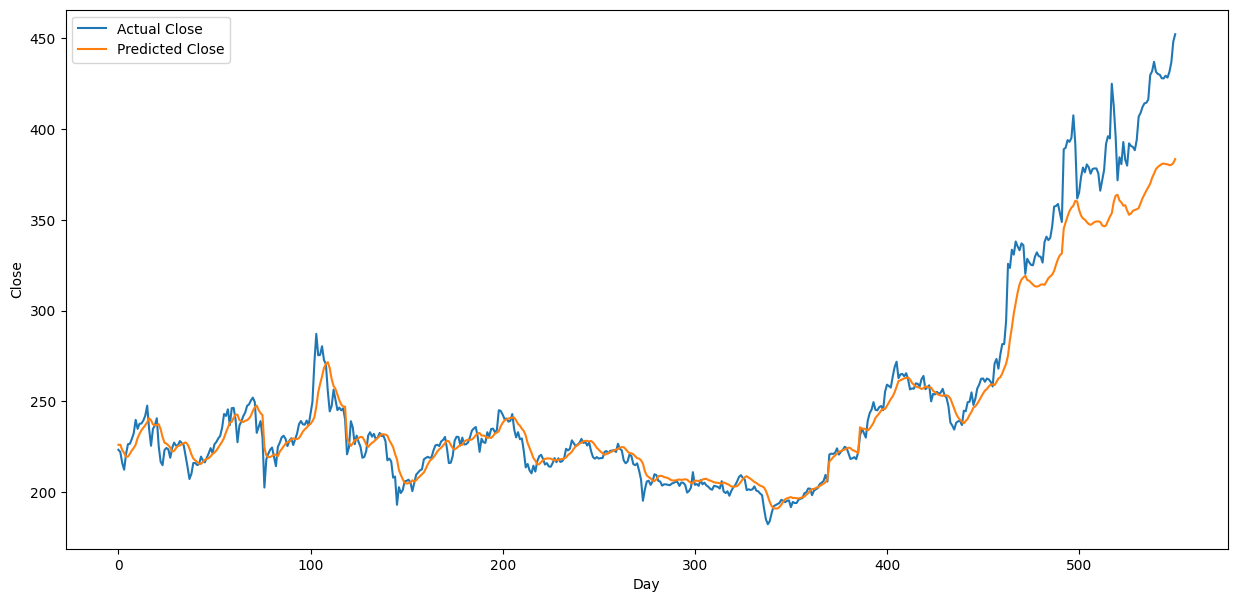

In [22]:
plt.figure(figsize=(15,7))

plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()